**tmpw0h7p9s5, equation 22**

Checking whether the equation I have written down in Overleaf is correct!

--> From below you can extract the minimum amount of decimal point necessary to get a validation MSE between 103.88 and 103.89

In [21]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

np.random.seed(10)

In [22]:
def round_expr(expr):
    d = {}
    for n in expr.atoms(sp.Number):
        d[n] = sp.Number('%.6g'%n)
    return expr.xreplace(d)

In [23]:
no_of_regimes = 2
regime = 1

**Read data**

In [24]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [25]:
path_data = os.path.join('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

# Load the input data and pick the five best features (rh, ta, clw, cli, rh_z)
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [26]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [27]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [28]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del training_folds, validation_folds
gc.collect()

2647

In [29]:
if no_of_regimes > 1:
    # Already remove the regime with clw + cli = 0
    reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
    flattened_input_train = flattened_input_train[reg_not_0_train]
    flattened_output_train = flattened_output_train[reg_not_0_train]

    reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]
    flattened_input_valid = flattened_input_valid[reg_not_0_valid]
    flattened_output_valid = flattened_output_valid[reg_not_0_valid]

In [30]:
flattened_input_valid.shape

(62640810, 5)

In [31]:
loc

{'rh': 0, 'ta': 1, 'clw': 2, 'cli': 3, 'rh_z': 4}

Optimize coefficients

In [32]:
# (146715*rh_z)**2*(rh_z+0.00286) == (rh_z)**2*(21525291225*rh_z+61562332.903500006) 

In [33]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func(X):
    rh = X[:, 0] 
    ta = X[:, 1] 
    clw = X[:, 2] 
    cli = X[:, 3]
    rh_z = X[:, 4]
    
    # (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (2.44602578e+02, 6.50754419e-02, 3.87865894e-02, 3.38579968e+01, 4.21678865e+03, 1.87848876e+01, 2.19807008e+03, 1.34231436e+05, 3.11805366e-03, 1.51425129e+00, 5.48080889e+00, 1.70666033e-06, 1.04823218e+00, 1.57514190e-04)
    (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 20000000000, 60000000, 8641, 32544, 0.0106, 1, 1)
    
    # Modified to always satisfy RH-constraint
    rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    I1 = a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7
    I2 = (rh_z)**2*(a_8*rh_z+a_9) 
    I3 = -B/(a_10*clw+a_11*cli+eps)
    
    return I1 + I2 + I3

In [34]:
def objective(X,Y):
    '''
        The objective function.
    '''
    train_preds = np.minimum(np.maximum(func(X), 0), 100) 
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

The Valid MSE should be close to 103.88895

In [35]:
# From finding_symmetries/pysr_results_dyamond_on_regimes/save_optimized_eqns.ipynb
mse_reg_0 = 0.0353
n_0 = 32419018
n_21 = 62640812
N = n_0 + n_21

valid_reg_mse = objective(flattened_input_valid, flattened_output_valid)

print('On the entire dataset')
print('Valid MSE: %.5f'%((n_0*mse_reg_0 + n_21*valid_reg_mse)/N))

On the entire dataset
Valid MSE: 103.47387


In [36]:
a1 = 203
a2 = 0.06588
a4 = 33.87
a5 = 4224.6
    
print(a2/(2*a1))
print(a4/(2*a1))
print(a5/(2*a1))

0.00016226600985221675
0.08342364532019704
10.405418719211823


**Plot I1, I2, I3**

In [37]:
# Define the bounds
rh_min = round(np.min(input_data[:, loc['rh']]), 1)
rh_max = round(np.max(input_data[:, loc['rh']]), 1)
ta_min = round(np.min(input_data[:, loc['ta']]))
ta_max = round(np.max(input_data[:, loc['ta']]))
rh_z_min = np.min(input_data[:, loc['rh_z']])
rh_z_max = np.max(input_data[:, loc['rh_z']])
clw_min = np.min(input_data[:, loc['clw']])
clw_max = np.max(input_data[:, loc['clw']])
cli_min = np.min(input_data[:, loc['cli']])
cli_max = np.max(input_data[:, loc['cli']])

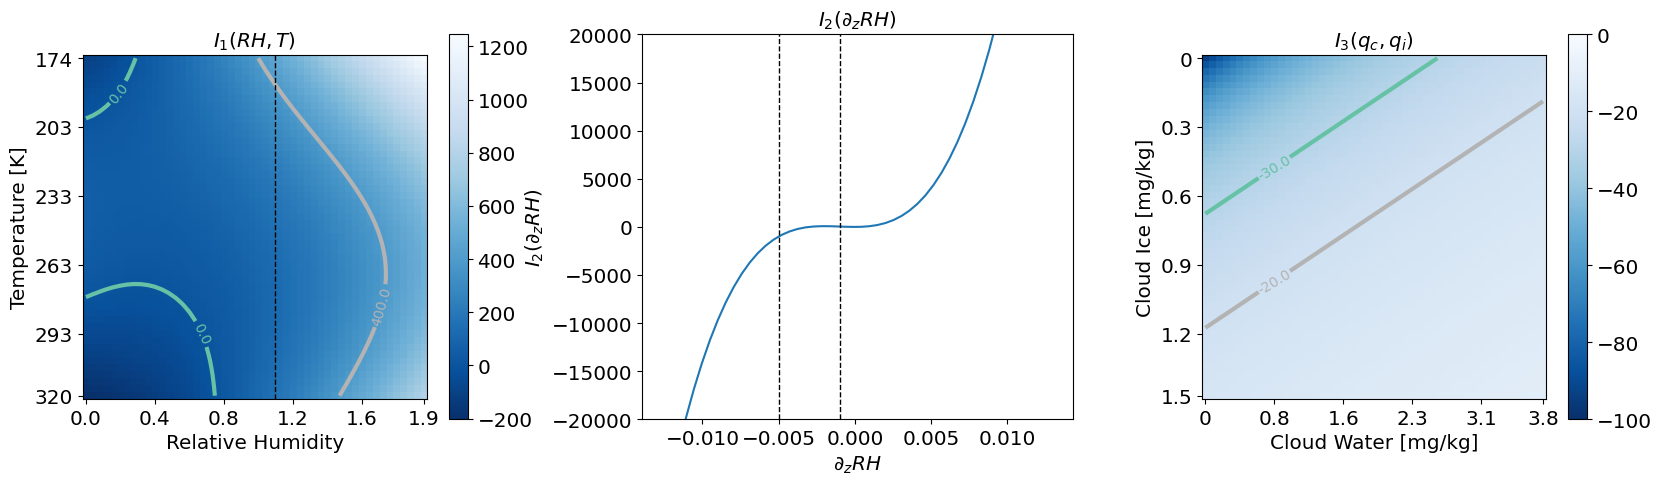

In [39]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from matplotlib import colors

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'

# Setting up the figure
fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# # Decrease size of second subplot
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])

plot_titles = ['$I_1$', '$I_2$', '$I_3$']

axes = tuple(np.arange(len(plot_titles)))

# Number of pixels in x- and y-direction
N_x = 50
N_y = 50

for i, title_name in enumerate(plot_titles):
    
    # First subplot
    if i == 0:
        # Set up the meshgrid
        x = np.linspace(rh_min, rh_max, N_x)
        y = np.linspace(ta_min, ta_max, N_y)
        X,Y = meshgrid(x, y)

        Z = 203*X**2+(0.06588*X-0.03969)*Y**2-33.87*X*Y+4224.6*X+18.95*Y-2202.6

        ax = plt.subplot(1, 3, 1, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        ax.set_xticklabels(['%.1f'%val for val in [x[0],x[10],x[20],x[30],x[40],x[49]]])
        ax.set_yticklabels(['%d'%val for val in [y[0],y[10],y[20],y[30],y[40],y[49]]])
    
        im = ax.imshow(Z, cmap='Blues_r') 
        cset = ax.contour(Z, [0, 400], linewidths=3,cmap=cm.Set2)
        plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
        colorbar(im)
        
        plt.xlabel('Relative Humidity')
        plt.ylabel('Temperature [K]')
        plt.title('$I_1(RH, T)$')
        
        plt.axvline(x=(50/2)*1.1, ls='--', color='black', lw=1)
        
    # Second subplot
    if i == 1:
        x = np.linspace(rh_z_min, rh_z_max, N_x)
        Z = x**2*(20000000000*x+60000000) 
        
        ax = plt.subplot(1, 3, 2)
        ax.plot(x, Z)
        
        plt.xlabel('$\partial_zRH$')
        # plt.ylabel('$I_2(\partial_zRH)$')
        plt.title('$I_2(\partial_zRH)$')
        
        plt.axvline(x=-0.005, ls='--', color='black', lw=1)
        plt.axvline(x=-0.001, ls='--', color='black', lw=1)
        
        plt.ylim([-20000,20000])
     
    # Third subplot
    if i == 2:
        # Set up the meshgrid
        x = np.linspace(clw_min, clw_max/500, N_x)
        y = np.linspace(cli_min, cli_max/500, N_y)
        X,Y = meshgrid(x, y)

        Z = -1/(8641*X + 32544*Y + 0.0106)

        ax = plt.subplot(1, 3, 3, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
        ax.set_xticklabels(['0'] + ['%.1f'%val for val in [10**6*x[10],10**6*x[20],10**6*x[30],10**6*x[40],10**6*x[49]]])
        ax.set_yticklabels(['0'] + ['%.1f'%val for val in [10**6*y[10],10**6*y[20],10**6*y[30],10**6*y[40],10**6*y[49]]])
    
        im = ax.imshow(Z, cmap='Blues_r', vmin=-100, vmax=0) 
        cset = ax.contour(Z, [-30, -20], linewidths=3,cmap=cm.Set2)
        plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
        colorbar(im)
        
        plt.xlabel('Cloud Water [mg/kg]')
        plt.ylabel('Cloud Ice [mg/kg]')
        plt.title('$I_3(q_c, q_i)$')
    
# cbar_ax = fig.add_axes([0.905, 0.15, 0.02, 0.7])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.ax.set_title('[%]')

# plt.savefig('./I1_I2_I3.pdf', bbox_inches='tight')

In [91]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['pa']])

90112.09995917694

In [93]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['rh']])

0.8658036636883503

In [92]:
np.mean(input_data[:, loc_all['pa']])

60011.24409507568

In [94]:
np.mean(input_data[:, loc_all['rh']])

0.6029945613832925

In [97]:
np.mean(output_data[np.where(input_data[:, loc_all['rh_z']] < -0.003)])

15.316176

In [98]:
np.mean(output_data)

44.76352

In [99]:
# Inversion
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['ta_z']])

0.07755888515796042

In [102]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['ta']])

268.34683583471985

In [109]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['hus']])

0.005386772525790015

In [115]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['cli']])

7.684398365746303e-07

In [116]:
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['clw']])

5.870931955165077e-06

In [119]:
np.mean(input_data[:, loc_all['cli']])

3.38140534964207e-06

In [118]:
np.mean(input_data[:, loc_all['clw']])

2.2772490737880113e-05

(array([3.38463000e+05, 9.97881000e+05, 2.09426100e+06, 2.29767300e+06,
        2.04254300e+06, 2.67607400e+06, 5.95270500e+06, 1.20947480e+07,
        1.00407515e+08, 1.56277631e+08]),
 array([ 50132.79296875,  55728.07773438,  61323.3625    ,  66918.64726562,
         72513.93203125,  78109.21679688,  83704.5015625 ,  89299.78632812,
         94895.07109375, 100490.35585938, 106085.640625  ]),
 <BarContainer object of 10 artists>)

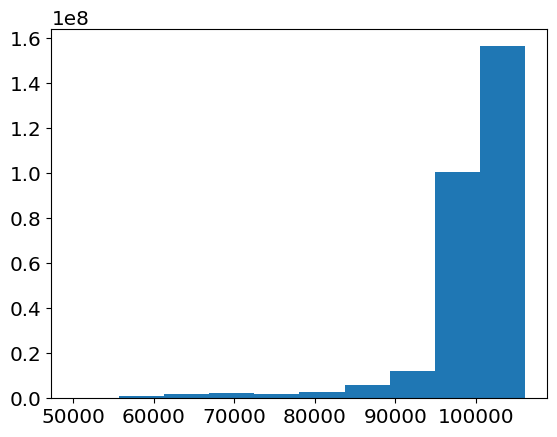

In [121]:
plt.hist(input_data[:, loc_all['ps']])

In [104]:
#
np.mean(input_data[np.where(input_data[:, loc_all['rh_z']] < -0.003), loc_all['ps']])

90141.82155667491